<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/deep_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tf_agents

     |████████████████████████████████| 1.2MB 7.5MB/s 


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Let's start with some helper functions to deal with Black-Scholes based option pricing (from Tomas Björk's book "Arbitrage Theory in Continuous Time"):

In [3]:
def compute_d1(S, K, r, sigma, T, t):
    # time to maturity
    ttm = T - t
    return (tf.math.log(S/K) + (r + sigma**2/2)*ttm) / (sigma * tf.sqrt(ttm))

def compute_d2(S, K, r, sigma, T, t):
    ttm = T - t
    return compute_d1(S, K, r, sigma, T, t) - sigma * tf.sqrt(ttm)

def compute_bs_price(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t

    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(ttm)

    price = S*normal.cdf(d1) - tf.exp(-r*ttm)*K*normal.cdf(d2)

    return price

def compute_delta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    return normal.cdf(compute_d1(S, K, r, sigma, T, t))

def compute_gamma(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return normal.prob(d1) / (S*sigma*tf.sqrt(ttm))

def compute_rho(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d2 = compute_d2(S, K, r, sigma, T, t)
    return K*ttm*tf.exp(-r*ttm)*normal.cdf(d2)

def compute_theta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(ttm)
    theta = (
        - S*normal.prob(d1)*sigma / (2*tf.sqrt(ttm))
        - r*K*tf.exp(-r*ttm)*normal.cdf(d2)
    )

    return theta

def compute_vega(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return S*normal.prob(d1)*tf.sqrt(ttm)

In [9]:
print("option price:", compute_bs_price(100, 100, 0.01, 1., 10., 1.))
print("delta:", compute_delta(100, 100, 0.01, 1., 10., 1.))
print("gamma:", compute_gamma(100, 100, 0.01, 1., 10., 1.))
print("rho:", compute_rho(100, 100, 0.01, 1., 10., 1.))
print("theta:", compute_theta(100, 100, 0.01, 1., 10., 1.))
print("vega:", compute_vega(100, 100, 0.01, 1., 10., 1.))

option price: tf.Tensor(87.23028, shape=(), dtype=float32)
delta: tf.Tensor(0.93699163, shape=(), dtype=float32)
gamma: tf.Tensor(0.0004125426, shape=(), dtype=float32)
rho: tf.Tensor(58.21999, shape=(), dtype=float32)
theta: tf.Tensor(-2.1274018, shape=(), dtype=float32)
vega: tf.Tensor(37.128834, shape=(), dtype=float32)


In [5]:
@tf.function
def sample_log_diff_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1):
    dX = (mu - 0.5*sigma**2)*dt \
      + sigma*tf.random.normal(shape=(n, length), mean=mu, stddev=tf.sqrt(dt))
    
    return dX

@tf.function
def sample_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1):
    log_diffs = sample_log_diff_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1)
    
    diffs = tf.concat([tf.ones(shape=(n, 1)), tf.exp(log_diffs)], axis=1)
    samples = S*tf.math.cumprod(diffs, axis=1)

    return samples#tf.concat([S, samples], axis=0)

tf.random.set_seed(5.)
s = sample_geom_bm(100, 10)

In [6]:
s = sample_geom_bm(100, 10)
s

<tf.Tensor: shape=(100, 11), dtype=float32, numpy=
array([[1.        , 1.0974238 , 0.71832657, ..., 0.39955455, 0.368409  ,
        0.38680264],
       [1.        , 0.7752297 , 0.40833664, ..., 0.30917856, 0.24705546,
        0.33697325],
       [1.        , 0.68553656, 0.63368267, ..., 0.6274556 , 0.37316018,
        0.4771795 ],
       ...,
       [1.        , 1.2476795 , 1.153329  , ..., 0.25429204, 0.162533  ,
        0.148301  ],
       [1.        , 0.803194  , 0.8427608 , ..., 2.3499584 , 1.7348535 ,
        1.6584028 ],
       [1.        , 0.92203605, 0.656608  , ..., 0.6178499 , 0.79343677,
        0.50394624]], dtype=float32)>

In [21]:
tf.concat([tf.zeros(shape=(s.shape[0], 1)), s], axis=1)

<tf.Tensor: shape=(100, 11), dtype=float32, numpy=
array([[0.        , 0.6251564 , 0.49763903, ..., 0.18157321, 0.18097438,
        0.16723149],
       [0.        , 1.3549161 , 1.353938  , ..., 0.6231236 , 0.6261552 ,
        0.46337917],
       [0.        , 1.1207817 , 1.7449888 , ..., 1.4048334 , 1.6169754 ,
        1.1931492 ],
       ...,
       [0.        , 0.5728698 , 0.43603513, ..., 0.20255673, 0.16738254,
        0.12182252],
       [0.        , 1.0406234 , 0.72546494, ..., 0.7047383 , 0.565912  ,
        0.55625033],
       [0.        , 1.0827826 , 1.2559961 , ..., 0.90339065, 0.67733085,
        0.64792544]], dtype=float32)>

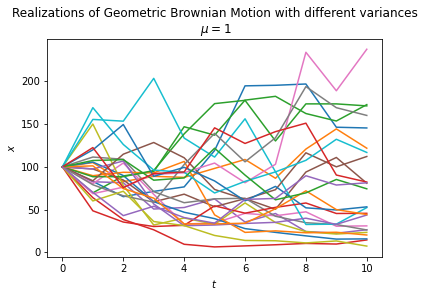

In [24]:
import matplotlib.pyplot as plt

x = tf.transpose(sample_geom_bm(25, 10))
plt.plot(100*x)
#plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()


     |████████████████████████████████| 1.2MB 14.7MB/s 


In [7]:
import numpy as np
import tf_agents
import tf_agents.environments as tfae
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts


class CardGameEnv(tfae.py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
      self._episode_ended = True
    elif action == 0:
      new_card = np.random.randint(1, 11)
      self._state += new_card
    else:
      raise ValueError('`action` should be 0 or 1.')

    if self._episode_ended or self._state >= 21:
      reward = self._state - 21 if self._state <= 21 else -21
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [ ]:
array_spec.

What is necessary for observation and action state:

- Price of underlying
- How many stocks are held
- How many stocks do we want to buy 
- Config of the option 

In [53]:
class HedgeCallEnv(tfae.py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.ArraySpec(
        shape=(), dtype=np.float32, name="action")
    # price, time, current position of stocks.
    # S, K, r, sigma, T, t, current position of stocks
    self._observation_spec = array_spec.ArraySpec(
        shape=(7,), dtype=np.float32, name="observation")
    self._state = np.array([100., 100., 0.01, 1., 10., 0.0, 0.0], dtype="float32")

    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = np.array([100., 100., 0.01, 1., 10., 0.0, 0.0], dtype=np.float32)
    self._episode_ended = False
    return ts.restart(self._state)

  def _step(self, action):

    state_vec = self._state

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Update position in underlying
    state_vec[-1] += action
    
    # Update price of underlying
    state_vec[0] *= tf.exp(sample_log_diff_geom_bm(
        n=1, 
        length=1, 
        S=state_vec[0], 
        mu=0., 
        sigma=state_vec[3], 
        dt=0.1)).numpy()
    
    # Update time
    state_vec[5] += 0.1

    if state_vec[4] <= state_vec[5]:
      value_call = tf.maximum(0, state_vec[0] - state_vec[1])

      # In order for the episode not going on forever.
      self._episode_ended = True
    else:
      value_call = compute_bs_price(
          S=state_vec[0],
          K=state_vec[1],
          r=state_vec[2],
          sigma=state_vec[3],
          T=state_vec[4],
          t=state_vec[5])
      
    value_stock_position = state_vec[0]*state_vec[-1]

    # reward = negative hedge error = Value position in share - value of option
    reward = -tf.abs(value_stock_position - value_call).numpy()

    self._state = state_vec

    if self._episode_ended:
      return ts.termination(self._state, reward=reward)
    else:
      return ts.transition(self._state, reward=reward)

In [54]:
environment = HedgeCallEnv()
tfae.utils.validate_py_environment(environment, episodes=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in float_scalars


In [40]:
?tf_agents.specs.array_spec.ArraySpec

In [ ]:
    if self._episode_ended:
      reward = self._state - 21 if self._state <= 21 else -21
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [18]:
_a = 5
def f():
  if _a:
    print(_a)

f()

5


In [19]:
_state = tf.Variable([100., 100., 0.01, 1., 10., 0.0, 0.0])
_episode_ended = False

In [20]:
_episode_ended

False

In [34]:
# S, K, r, sigma, T, t, current position of stocks
_state = tf.Variable([100., 100., 0.01, 1., 10., 0.0, 0.0])
_episode_ended = False

def _step(action):
    state_vec = _state.numpy()
    global _episode_ended
    if _episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Update position in underlying
    state_vec[-1] += action
    
    # Update price of underlying
    state_vec[0] *= tf.exp(sample_log_diff_geom_bm(
        n=1, 
        length=1, 
        S=state_vec[0], 
        mu=0., 
        sigma=state_vec[3], 
        dt=0.1))
    
    # Update time
    state_vec[5] += 0.1

    if state_vec[4] <= state_vec[5]:
      value_call = tf.maximum(0, state_vec[0] - state_vec[1])

      # In order for the episode not going on forever.
      _episode_ended = True
    else:
      value_call = compute_bs_price(
          S=state_vec[0],
          K=state_vec[1],
          r=state_vec[2],
          sigma=state_vec[3],
          T=state_vec[4],
          t=state_vec[5])
      
    value_stock_position = state_vec[0]*state_vec[-1]

    # reward = negative hedge error = Value position in share - value of option
    reward = -tf.abs(value_stock_position - value_call)

    _state.assign(state_vec)

    return reward



In [35]:
tf.maximum(2, 1)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [36]:
??_step

In [37]:
print(_state)
_step(2.)
print(_state)

<tf.Variable 'Variable:0' shape=(7,) dtype=float32, numpy=
array([1.e+02, 1.e+02, 1.e-02, 1.e+00, 1.e+01, 0.e+00, 0.e+00],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(7,) dtype=float32, numpy=
array([1.02495766e+02, 1.00000000e+02, 9.99999978e-03, 1.00000000e+00,
       1.00000000e+01, 1.00000001e-01, 2.00000000e+00], dtype=float32)>


In [12]:
arr = tf.Variable([100., 100., 0.01, 1., 10., 0.0, 0.0]).numpy()
arr[3:5]

array([1.e+02, 1.e+02, 1.e-02, 1.e+00, 1.e+01, 0.e+00, 0.e+00],
      dtype=float32)

In [15]:
arr[4] += 1

In [16]:
arr[4]

11.0

In [38]:
arr = np.array([1,2,3,4])
print(arr)
arr[-2]

[1 2 3 4]


3

In [36]:
environment = CardGameEnv()
tfae.utils.validate_py_environment(environment, episodes=5)

In [32]:
from tf_agents import utils
utils.validate_py_environment(environment, episodes=5)

AttributeError: ignored

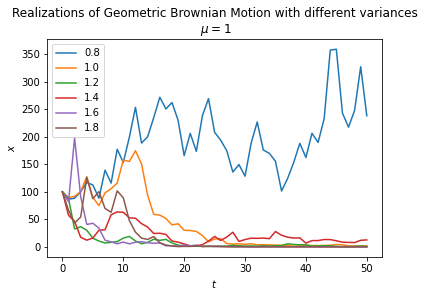

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu = 0.01
n = 50
dt = 0.1
x0 = 100
#np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()
